In [1]:
from axikernels.core.handlers import element_output
from axikernels.core.kernels import objective_function, kernel
from axikernels.aux import mesher
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# Sensitivity kernel based on 1D background Earth model

In this notebook we will compute a simple P wave sensitivity kernel (banana doughnut).

## Run forward simulation 

The first step is to set up a forward simulation with element output:

1. We use an already existing mesh suitable for 50s period simulations based on the prem isotropic and elastic model (prem_iso_elastic_50s.e). 
2. For the inparam.nr.yaml we just need to make sure to use a constant nr=5 in the whole domain since we are doing a 1D simulation (this is where the speed-up happens compared to other full 3D wave solvers).
3. For the source we can use whatever we like. In this case I used an explosion source. 
4. Finally, in the inparam.output.yaml we will put 1 element group for the mantle, 1 for the outer core, and 1 for the inner core. Even though the simulation runs using 16 GLL points on each element, we will output only 9 to save some disk space. 
5. Run axisem3d (see at the end details about computational costs)

After running the simulation, we create an *ElementOutput* object to hold the simulation information.

In [2]:
forward_simulation = element_output.ElementOutput(path_to_element_output='data/3D_KERNEL_EXAMPLE_30s/output/elements')

## Run Backward simulation

The next step depends on what kind of objective function we want. The most popoular objective function is:
$$
\chi = \frac{1}{2}\mathcal{T}^2
$$
where $\mathcal{T}$ is the cross-correlation time shift between some observed displacement $\bm{u}(m;\bm{r}_0,t)$ (based on the real or a synthetic earth model $m$) and the forward displacement $\bm{u}_0(m_0;\bm{r}_0,t)$ at the same receiver location $\bm{r}_0$ (computed at the reference Earth $m_0$). We will use this objective as well:

In [3]:
time_shift_objective = objective_function.XObjectiveFunction(forward_simulation)

The backward field is computed over the same mesh as the forward field, the only difference is the source, which for the backward simulation is given by:
$$
f^{\dagger} = \frac{\mathcal{T} W[\dot{\bm{u}}] }{\left| W[\dot{\bm{u}}] \right|^2_2}
$$
Here $\dot{\bm{u}}$ is the time derivative of the forward displacement field evaluated at the location of the receiver. $W$ is the operator that represents "time windowing", which is needed if we want to isolate a certain phase. Mathematically, the backward field would be computed by solving the same wave equation as for the forward simulation but backwards in time and with $f^{\dagger}$ replacing the earthquake source. 

The *.compute_backward_field()* method of our XObjectiveFunction instance will:
1. Create a new simulation directory for the backward simulation 
2. Create an adjoint source and save it in the input directory of the backward simulation directory as three STF functions.
3. Run the backward simulation

This method needs the following inputs:
1. Time shift $\mathcal{T}$ in seconds
2. The location of the reciever (in form [radius, latitude, longitude]) in meters and degrees.
3. Left and right time limits (in seconds) of the window containing the desired phase 
4. The number of cores to be used for the AxiSEM3D simulation
5. The channel on which we observe the forward wavefield at the receiver.

In this case we will isolate a P wave at 50 degrees distance from the source. 

Loading and interpolating: 100%|██████████| 1/1 [00:00<00:00, 37.94point/s]


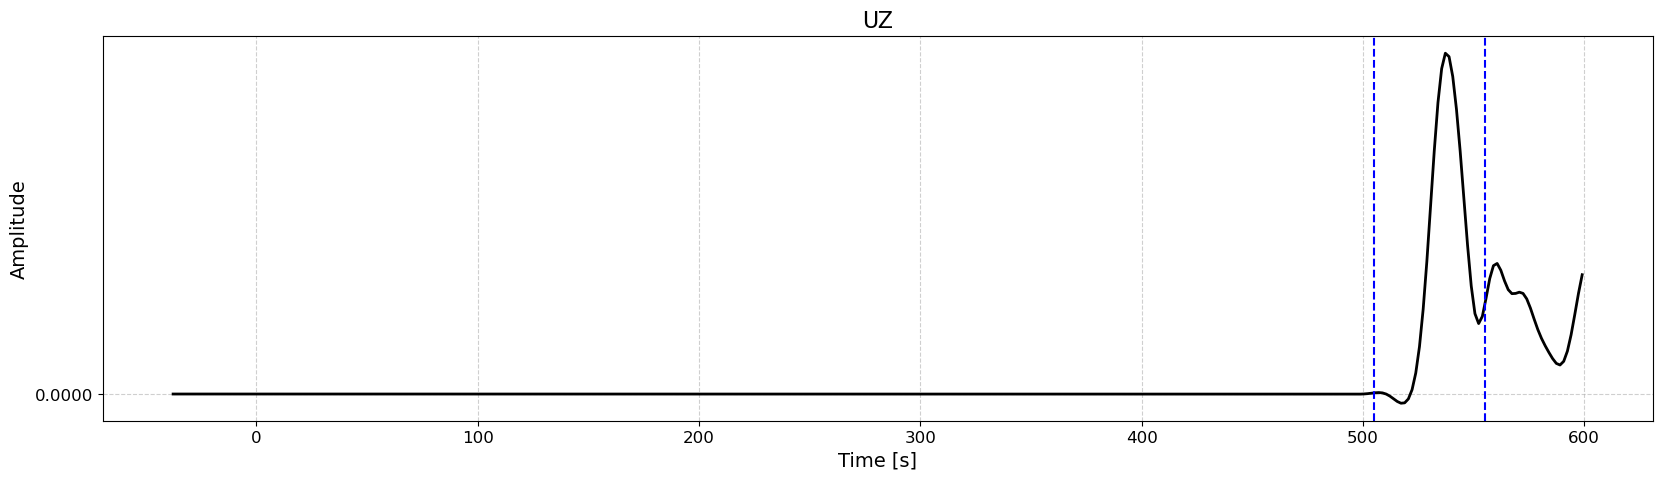

In [4]:
receiver_point = [6371000, 0, 50]
window = [530-25, 530+25]
trace = forward_simulation.load_data(receiver_point, channels=['UZ'])

plt.figure(figsize=(20, 5))

# Increase line width and change color
plt.plot(forward_simulation.element_groups_info['mantle']['metadata']['data_time'],
         trace[0][0], color='black', linewidth=2)

plt.xlabel('Time [s]', fontsize=14)
plt.ylabel('Amplitude', fontsize=14)

# Add vertical bars at the ends of the window with labels
plt.axvline(x=window[0], color='blue', linestyle='--')
plt.axvline(x=window[1], color='blue', linestyle='--')

# Set y-ticks to be multiples of a base value
base = 0.0005  # Change this to the desired base value
plt.gca().yaxis.set_major_locator(MultipleLocator(base))

# Increase tick size
plt.tick_params(axis='both', which='major', labelsize=12)

# Add grid
plt.grid(True, linestyle='--', alpha=0.6)

# Add title
plt.title('UZ', fontsize=16)
plt.savefig('window_3D_P.png')
plt.show()

In [5]:
%matplotlib inline
time_shift_objective.compute_backward_field(tau=2, receiver_point=receiver_point,
                                             window=window, cores=16, channel = 'UZ')
backward_simulation = element_output.ElementOutput(path_to_element_output='data/backward_3D_KERNEL_EXAMPLE_30s_P/output/elements')

Now we should see a new directory called "backward_1D_KERNEL_EXAMPLE". We can visualize both the forward and backward wavefield (Z and R components only, since T is 0) using an animation

In [6]:
""" forward_simulation.animation([6371000, 0, 0], [6371000, 0, 50], channels=['UZ', 'UR'],
                             resolution=300, domains=[[3480000, 6371000, -np.pi/2, np.pi/2]])

backward_simulation.animation([6371000, 0, 0], [6371000, 0, 50], channels=['UZ', 'UR'],
                             resolution=300, domains=[[3480000, 6371000, -np.pi/2, np.pi/2]])
 """

" forward_simulation.animation([6371000, 0, 0], [6371000, 0, 50], channels=['UZ', 'UR'],\n                             resolution=300, domains=[[3480000, 6371000, -np.pi/2, np.pi/2]])\n\nbackward_simulation.animation([6371000, 0, 0], [6371000, 0, 50], channels=['UZ', 'UR'],\n                             resolution=300, domains=[[3480000, 6371000, -np.pi/2, np.pi/2]])\n "

We will load this simulation and use it as an argument together with the foward simulation to form a "Kernel" object. While the XObjectiveFunction class deals with creating the adjoint wavefield, the Kernel class deals with computing the actual kernels.

In [7]:
ker = kernel.Kernel(forward_simulation, backward_simulation)

With the forward and backward data at hand, we can compute volumetric or geometric sensitivity kernels. Volumetric sensitivity kernels can be visualized both on a slice through the Earth, or on a spherical shell centered on the Earth's center. 

In the *mesher* module there are two classes that deal with slices and shells. The *SliceMesh* class takes in the following arguments:
1. **point1, point2**: these are in the [rad, lat lon] format where radius is in the same units as used in the basemodel (ideal to stick with SI units everywhere) and the latitude and longitude are by default in degree (but passing the argument *degrees=False* will switch to radians). These two points, together with the Earth's center, determine a great circle disk/slice through the Earth on which the kernel will be computed.
2. **domains**: this has the form [[rad_min, rad_max, theta_min, theta_max],[rad_min, rad_max, theta_min, theta_max],...]. By default the slice contains the full great circle disk, but if we want, we can restrict it to one or more regions described by a min and max radius, and a min and max angle from point1 in the direction towards point2. Obviously, the kernel can only be computed in regions where we have an output from the simulation. For example, if in the inparam.output.yaml file we specified only the mantle region as an element group, then the kernel will be computed only in that region intersected with the regions specified in the domains argument.
3. **resolution**: The mesh points on the slice are placed in a uniform grid of size *resolution* X *resolution*


In [8]:
source_location = [forward_simulation.Domain_Radius - forward_simulation.source_depth,
                    forward_simulation.source_lat,
                    forward_simulation.source_lon]
receiver_point = [6371000, 0, 50]
domains = [[4000000, 6371000, np.rad2deg(-30), np.rad2deg(80)]]
slice = mesher.SliceMesh(point1=source_location,
                     point2=receiver_point,
                     domains=domains,
                     resolution=200)


When the mesh is created, the coordinates of the points found within the specified domains will be saved in the *.points* attribute. Thse points can then be passed to any *.evaluate_...() * method to compute the sensitivity at those points. Currently there are the following volumetric kernel methods:

---------key-------method------------------
- 'rho_0': self.evaluate_rho_0,
- 'lambda': self.evaluate_lambda,
- 'mu': self.evaluate_mu,
- 'rho': self.evaluate_rho,
- 'vp': self.evaluate_vp,
- 'vs': self.evaluate_vs,

So let's say we want to compute the vp sensitivity kernel on the mesh computed above (decrease the resolution or restrict your domains if you want a faster computation):

In [9]:
parameter = 'vp'
sensitivity_kernel_slice = ker.evaluate_vp(slice.points)
"""
# or alternatively using:
sensitivity_kernel = ker.kernel_types[parameter](slice.points) """

Loading and interpolating: 100%|██████████| 18808/18808 [03:44<00:00, 83.76point/s] 


'\n# or alternatively using:\nsensitivity_kernel = ker.kernel_types[parameter](slice.points) '

The resulting sensitivity data can be then passed in the *.plot_on_mesh()* method of the mesh to have it plotted. *high_range* stretches the sensitivity values to show the weaker signals in the kernel. This is often needed since the sensitivity kernels take very large values near the source.

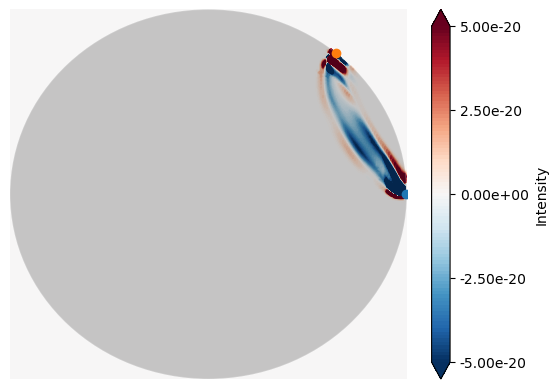

In [10]:
slice.plot_on_mesh(data=sensitivity_kernel_slice, cbar_range=[-5e-20, 5e-20])